<a href="https://colab.research.google.com/github/RaulAtLehigh/CSE337_P1/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


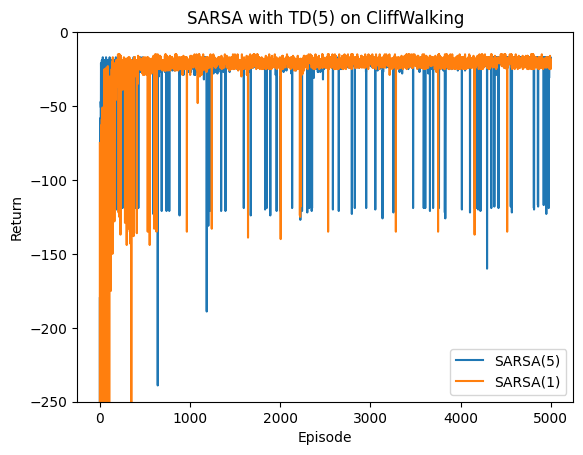

In [11]:



"""
 Starter code for Exercise (you can use this code, or extend your code from previous lab)
 Implement SARSA with TD(5) on CliffWalking-v1
 """

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1") # create environment

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.05         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes): # Loop for each episode
    state, _ = env.reset() # s
    action = epsilon_greedy(state) # a

    # Buffers to store the trajectory
    states = deque([state])
    actions = deque([action])
    rewards = deque()

    T = float("inf")
    t = 0

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the reward and the next state/action
            rewards.append(reward)
            states.append(next_state)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                actions.append(next_action)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            G = 0.0
            # Accumulate discounted rewards for n steps
            for i in range(n_step):
                if tau + i < len(rewards):
                    G += (gamma ** i) * rewards[tau + i]

            # Add the bootstrap value if not terminal
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # Update Q-value
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1: # Break when the update for the last state is done
            break

        t += 1

    # Calculate total return for the episode for plotting
    # Note: Using `len(rewards)` as it directly reflects steps taken.
    episode_returns.append(sum(rewards))

# Now adding my one step sarsa from last class:

env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5000     # number of episodes to run
max_steps = 100     # safety cap
sarsaRewards = np.zeros(n_episodes)
# Q-learning parameters
learning_rate = 0.1 # alpha
discount_factor = 0.99 # lambda
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))

def greedyPolicy(state, Q): # assuming I can index by state
  return np.argmax(Q[state])

# call using action = self.greedyPolicy()
epsilon = .05

"""
if(step % (max_steps * epsilon) == 0):
      action = env.action_space.sample()
"""

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    action = greedyPolicy(state, Q)
    next_action = 0
    for step in range(max_steps):
        next_state, reward, terminated, truncated, info = env.step(action)
        # e-greedy policy
        if(step % (max_steps * epsilon) == 0):
          next_action = env.action_space.sample() # random for this one
        else:
          next_action = greedyPolicy(next_state, Q)
        total_reward += reward
        Q[state][action] = Q[state][action] + learning_rate* ((reward + discount_factor * (Q[next_state][next_action])) - Q[state][action])
        state = next_state
        action = next_action

        if terminated or truncated:
            break

    #print(f"Episode {episode+1}: total reward = {total_reward}")
    sarsaRewards[episode] = total_reward

env.close()

# Plot learning curve
plt.plot(episode_returns)
plt.plot(sarsaRewards)
plt.legend(["SARSA(5)", "SARSA(1)"])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title(f"SARSA with TD({n_step}) on CliffWalking")
plt.ylim([-250, 0])

plt.show()






**Discussion on Sarsa(1) vs Sarsa(5):**

It seems that 5-step sarsa converges much quicker for this cliff-walking example than simple 1-step sarsa. As you can see on the top left corner, the blue graph (sarsa(5)) has already reached a desirearble return whereas 1-step sarsa took much longer. I think this was expected, because as you take more steps into consideration, you can make more informed value predictions that you do when you just take one value and update the Q table.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
